
0: 640x384 12 persons, 1 bottle, 1 chair, 1 dining table, 2 laptops, 344.7ms
Speed: 70.0ms preprocess, 344.7ms inference, 41.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 10 persons, 1 bottle, 1 chair, 1 dining table, 2 laptops, 171.3ms
Speed: 6.4ms preprocess, 171.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 10 persons, 1 bottle, 2 cups, 3 chairs, 1 dining table, 4 laptops, 147.5ms
Speed: 4.0ms preprocess, 147.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 12 persons, 1 bottle, 1 cup, 2 chairs, 1 dining table, 4 laptops, 143.3ms
Speed: 3.0ms preprocess, 143.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 10 persons, 2 bottles, 3 chairs, 1 dining table, 5 laptops, 150.5ms
Speed: 4.0ms preprocess, 150.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 12 persons, 2 bottles, 1 cup, 4 chairs, 1 dining table, 5 laptops, 1 cell phone, 143.5m

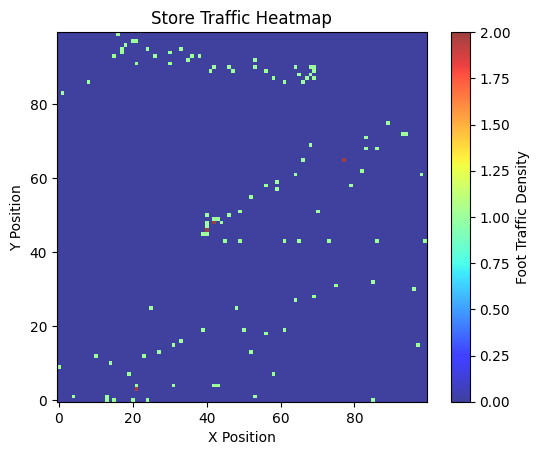

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import time

# Load YOLOv8 model
model = YOLO('yolov8n.pt')

# Set video path
VIDEO_PATH = r"C:\Users\nishi\store-analytics\yolov8\20250118_123057.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)

# Tracking people with (ID, entry_time)
people_tracking = {}
heatmap_data = []
zone_rect = (100, 100, 400, 400)  # Define a fixed zone (x1, y1, x2, y2)

# Start processing video
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    current_time = time.time()

    # Run YOLO detection
    results = model(frame)

    detected_people = []
    for result in results:
        for detection in result.boxes:
            if detection.cls == 0:  # Class 0 = 'person' in COCO dataset
                bbox = detection.xyxy[0].cpu().numpy().astype(int)
                centroid = ((bbox[0] + bbox[2]) // 2, (bbox[1] + bbox[3]) // 2)
                detected_people.append(centroid)

                # Check if the centroid is inside the zone
                if zone_rect[0] <= centroid[0] <= zone_rect[2] and zone_rect[1] <= centroid[1] <= zone_rect[3]:
                    heatmap_data.append(centroid)

                    # Track person’s time in the zone
                    person_id = str(centroid)  # Simple way to assign an ID
                    if person_id not in people_tracking:
                        people_tracking[person_id] = current_time  # Store entry time

                    # Draw the bounding box
                    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
                    cv2.putText(frame, f"ID {person_id[-4:]}", (bbox[0], bbox[1] - 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Draw zone rectangle
    cv2.rectangle(frame, (zone_rect[0], zone_rect[1]), (zone_rect[2], zone_rect[3]), (255, 0, 0), 2)

    # Display the video
    cv2.imshow('Tracking', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Calculate dwell time per person
dwell_times = {person: time.time() - entry_time for person, entry_time in people_tracking.items()}

# Print dwell time statistics
print("\n🔹 **Dwell Time Report** 🔹")
for person, duration in dwell_times.items():
    print(f"Person {person[-4:]} spent {duration:.2f} seconds in the zone.")

# Generate Heatmap
heatmap, xedges, yedges = np.histogram2d(
    [p[0] for p in heatmap_data], [p[1] for p in heatmap_data], bins=(100, 100)
)

# Display heatmap
plt.imshow(heatmap.T, cmap='jet', origin='lower', alpha=0.75)
plt.colorbar(label="Foot Traffic Density")
plt.title("Store Traffic Heatmap")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()
